In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Continuous Random Walk, Tile Coding and TD($\lambda$) with accumulating traces

### Construction of Tiles

In [0]:
num_of_tiles = 10
num_of_bins = 10 
def set_tiles(num_of_tiles = 10, num_of_bins = 10):
  tiles = []
  offset = (np.random.random(num_of_tiles)*2 -1)/9 # Random offsets 
  # between -0.1 and 0.1
  for i in range(num_of_tiles):
    tile = np.linspace(0, 1, num_of_bins) + offset[i]
    tiles.append(tile)
  return tiles

### Encoding and Helper Functions

In [0]:
def encode(location, tile):
  'Creates encoding wrt provided tile'
  enc = np.zeros(num_of_bins)
  for i in range(num_of_bins):
    if location < tile[i]:
      break
  enc[i] = 1
  return enc

In [0]:
def get_S(location, tiles, debug=False):
  'Converts location to tile coding'
  state = []
  deb = []
  for j in tiles:
    e = encode(location, j)
    state.extend(e)
    deb.append(e)
  if (location<=0) or (location>=1):
    state = np.zeros(num_of_tiles*num_of_bins)
  if debug:
    return deb
  else:
    return state

In [0]:
def v_hat(w, x):
  return np.dot(w, x)

In [0]:
def env(a, s):
  'given action and current state, it gives next state and reward'
  done = False
  s_ = a + s 
  if (s_ >= 1) or (s_ <= 0):
    r = s_
    done = True
  else:
    r = 0  
  return r, s_, done

### TD($\lambda$) Algorithm

In [0]:
def td(alpha, lambdaa, num_episodes, tiles):
  gamma = 1
  w = np.zeros(num_of_tiles*num_of_bins) # weights
  for i in range(num_episodes):
    S = 0.5 # the starting state
    z = np.zeros(num_of_tiles*num_of_bins) # eligibility trace vector
    while True:
      A = (np.random.random()*4 -2)/10 # choosing uniform action
      # between -0.2 and 0.2
      R, S_, done = env(A, S)
      z = gamma*lambdaa*z + get_S(S, tiles) # gradient of linear function 
      delta = R + gamma*v_hat(w, get_S(S_, tiles)) - v_hat(w, get_S(S, tiles)) # td error
      w = w + alpha*delta*z # updating weights
      S = S_
      if done:
        break
  return w
    

### Experiments

In [0]:
lambdas = [1, 0.99, 0.975, 0.95, 0.9, 0.8, 0.4, 0]
alphas = np.linspace(0,1,21)/10
results = np.zeros([8, 21, 50])
points = np.linspace(0,1,21)
real_values = np.linspace(0,1,21)
real_values[-1] = 0 # Terminal states has zero value
for i in range(50):
  np.random.seed(i*12)
  tiles = set_tiles()
  for l in range(len(lambdas)):
    for a in range(len(alphas)):
      w = td(alphas[a], lambdas[l], 25, tiles)
      vals = []
      for j in points:
        vals.append(v_hat(w, get_S(j, tiles)))
      results[l, a, i] = np.sqrt(np.mean(np.power(real_values - vals,2)))

      


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
np.save('results.npy', results)

In [0]:
res_mean = np.mean(results, axis=2)
res_std = np.std(results, axis=2)

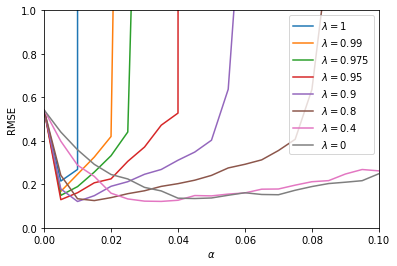

In [0]:
for lam in range(len(lambdas)):
  plt.plot(alphas, res_mean[lam, :], label=('$\lambda=$'+str(lambdas[lam])))
plt.axis([0, 0.1, 0, 1])
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('$\\alpha$')
plt.show()

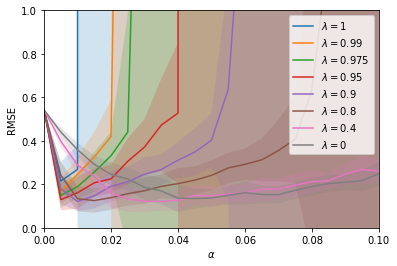

In [0]:
for lam in range(len(lambdas)):
  plt.plot(alphas, res_mean[lam, :], label=('$\lambda=$'+str(lambdas[lam])))
  plt.fill_between(alphas, res_mean[lam, :] - res_std[lam, :], 
                   res_mean[lam, :] + res_std[lam, :], alpha=0.2)
plt.axis([0, 0.1, 0, 1])
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('$\\alpha$')
plt.show()

### Comments

The graph corrects us at most of the points we discussed in the first theory quetion. Here we have a similar graph that is given in the TD($\lambda$) section of the book. WE can say that tile coding if an relatively efficient way to work on a continuous space. While solving this question I also tried a grid that has the same size of 10 tiles of the question eg 100. I see that tile coding outperform this grid even they have the same size. Thus, I can say that tile coding is a nice invention to carry the location information.

We have $\lambda=1$ which has the same nature with Monte Carlo methods. In that case, we give full credit to the earlier states, namely we have full consideration to the past cases. The cases that has $\lambda$ closer to $1$ tend to have small optimal $\alpha$. 

On the other hand, we have $\lambda=0$ which has the same nature with the one step TD method. Then, we consider only one state prior to the current state. The cases that has $\lambda$ closer to $0$ tend to have relatively large optimal $\alpha$.

Below I plotted the results using best parameters. It tends to underestimate the value of the satates which are below $0.5$. Whereas, it overestimates the value of the satates which are above $0.5$

Finally, we can say that chhosing the optimal $\alpha$, the optimal $\lambda$ for this task is around $0.9$. Hence, hte mixture of TD and MC methods lead us to the optimal way rather than the two extremes. Additionally, the variance increases with $\alpha$. In the discrete case(book example) they can go for all $\alpha$'s from $0$ to $1$. Hewever, we see that $alpha$ values more than $0.01$ cannot converge the optimal. 

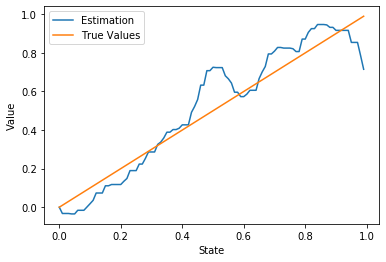

In [0]:
np.random.seed(12)
tiles = set_tiles()
w = td(0.005, 0.95, 25, tiles)
a = []
for i in range(100):
  a.append(v_hat(w, get_S(i/100, tiles)))
plt.plot([i/100 for i in range(100)], a, label='Estimation')
plt.plot([i/100 for i in range(100)], [i/100 for i in range(100)], label='True Values')
plt.plot()
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()